<div style="width:50%; float:left;">
    <img src="support_files/AIBS_banner.png" width="430" align="left">
</div>

<div style="width:50%; float:right;">
    <img src="support_files/Dipde_Nick_final.png" width="100" height="100" align="right">
</div>

<div style="width:100%; float:left;">
    <hr>
</div>



<div style="width:100%; float:left;">
    <h1>Tutorial: Population Density Modeling with DiPDE</h1>
</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Basic Introduction</h2>
<p>DiPDE (dipde) is a simulation platform for numerically solving the time evolution of coupled networks of neuronal populations. Instead of solving the subthreshold dynamics of individual model leaky-integrate-and-fire (LIF) neurons, dipde models the voltage distribution of a population of neurons with a single population density equation. In this way, dipde can facilitate the fast exploration of mesoscale (population-level) network topologies, where large populations of neurons are treated as homogeneous with random fine-scale connectivity.

<p>The population density approach in computational neuroscience seeks to understand the statistical evolution of a large population of homogeneous neurons. Beginning with the work of Knight and Sirovich <a href='#knight_sirovich' id='knight_sirovich_first_ref'>[1]</a>. (see also <a href='#knight_sirovich_2' id='knight_sirovich_2_first_ref'>[2]</a>), the approach typically formulates a partial integro-differential equation for the evolution of the voltage probability distribution receiving synaptic activity, and under the influence of neural dynamics. Neuronal dynamics typically follow from the assumption of a leaky integrate-and fire model. We implement a numerical scheme for computing the time evolution of the master equation for populations of leaky integrate-and-fire neurons with shot-noise synapses (for a similar approach, see <a href='#de_kamps' id='de_kamps_first_ref'>[3]</a>).
</div>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


<h2>ExternalPopulation:</h2> 

<p>This class provides a background drive to internal population. It is used as the source argument to a connection, in order to provide background drive.  `ExternalPopulation` has one required argument, defining the firing rate of the population; it can be set to a numeric value, a string that is interpretable by `sympy.parsing.sympy_parser.parse_expr`, or any python function that takes time (in units of seconds) as its argument. The following examples are all equvalent:

```python
    background_population = dipde.ExternalPopulation(100)
    background_population = dipde.ExternalPopulation("100")
    background_population = dipde.ExternalPopulation(lambda t: 100)
```




<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>InternalPopulation:</h2> 
<p>This class encapulates all the details necessary to propagate a population density equation driven by a combination of recurrent and background connections. The voltage (spatial) domain discretization is defined by linear binning from `v_min` to `v_max`, in steps of `dv` (all in units of volts). Here `v_max` defines the threshold of the neurons in the population, and `v_min` should be chosen sufficiently negative to minimize boundary effects.

```python
    internal_population = dipde.InternalPopulation(v_min=0, v_max=.02, dv=.001)
```

The initial voltage distribution of the probability density function can be specified by the optional kwarg `p0`.  When no value for `p0` is provided, a delta distribution centered at the rest potentail $v=0$ is used by default. Several notations for distibutions are supported, including discrete distributions defined by the user or through the `scipy.stats` module; the following are equvalient:

```python
    p0 = {'distribution':'delta', 'loc':0}
    p0 = '{"distribution":"delta", "loc":0}'
    p0 = ([0], [1])
    p0 = scipy.stats.rv_discrete(values=([0],[1]))
```

Continuous distributions from `scipy.stats` are also supported, and are automatically converted discretized by choosing interpolation points that uniformly sample the range of the cumulative distribution function into $N$ bins ($N=25$ by default).  The following example of a normally distributed initial voltage distribution ($\mu=0$, $\sigma=.001$) are equvalent:

```python
    p0 = scipy.stats.norm(scale=.003)
    p0 = scipy.stats.norm(loc=0, scale=.003)
    p0 = (scipy.stats.norm(loc=0, scale=.003), 25)
    p0 = {"distribution":"norm", "loc":0, "scale":0.003}
    p0 = {"distribution":"norm", "loc":0, "scale":0.003, "N":25}
    p0 = '{"distribution":"norm", "loc":0, "scale":0.003, "N":25}'
```

There are three options for the optinal kwarg `update_method`, which selects the numerical technique to solve the update of an `InternalPopulation`: `'exact'`, `'approx'`, and `'gmres'`.  The most accurate, `'exact'`, computes a matrix exponential at each timestep and is thus the most time consuming, and is therefore impractical for large simulations.  The `'approx'` method uses a Taylor series approximation to this matrix expontial.  The `'gmres'` option uses sparse storage, an implicit time-stepping scheme (backwards Eulers method), and gmres iteration (`scipy.sparse.linalg.gmres`) to update the voltage distribution; this can lead to significant speedups for large systems (i.e. `dv` and `dt` small). In `'approx'` and `'gmres'`, the optional kwarg `tol` controls numerical accuracy. Default initializations are:

```python
    InternalPopulation(v_min=0, v_max=.02, dv=.001, update_method='exact')
    InternalPopulation(v_min=0, v_max=.02, dv=.001, update_method='approx', tol=1e-12)
    InternalPopulation(v_min=0, v_max=.02, dv=.001, update_method='gmres', tol=1e-5)
```

Finally, the kwarg `tau_m` controls the membrane time constant, in units of seconds; the default value is ```python tau_m = .02 ```.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Connection:</h2> 

<p> The `Connection` class connects two populations, either an `ExternalPopulation` to an `InternalPopulation`, connecting two `InternalPopulation` instances, or recurrently connecting an `InternalPopulation` to itself. The first two required arguments are the `source` and `target` populations.  An additional kwarg, `nsyn`, corresponds to the average in-degree of a projection from the source population to the target population, and effectivly scales the firing rate coming from the source.  The following would produce idential results:

```python
    b1 = dipde.ExternalPopulation(100)
    i1 = dipde.InternalPopulation(v_min=0, v_max=.02, dv=.001)
    b1_i1 = dipde.Connection(b1, i1, 1, weights=.005)

    b1 = dipde.ExternalPopulation(50)
    i1 = dipde.InternalPopulation(v_min=0, v_max=.02, dv=.001)
    b1_i1 = dipde.Connection(b1, i1, 2, weights=.005)
```

The synaptic connetivity between the source and target is controlled by the synaptic weight distribution (the `weights` kwarg, in units of volts) and the delay distribution (the `delays` kwarg, in units of seconds).  These parameters can be set as scalars, or by the same distribution syntax outlined for parameterizing `p0` for `InternalPopulation`; the following are equvalent:

```python
    b1_i1 = dipde.Connection(b1, i1, 2, weights=0.002, delays=0.01)
    b1_i1 = dipde.Connection(b1, i1, 2, 
                             weights={'distribution':'delta', 'loc':0.002}, 
                             delays={'distribution':'delta', 'loc':0.01})
```

When specifying a synaptic delays, only causal distributions are acceptable, i.e. no negative values.  Additionally, if a connection from a `ExternalPopulation` with a constant firing rate has a nonzero delay, the entire history of that population (i.e. the inital data for hte connection) is assumed to be equal to that constatnt firing rate; in all other cases, the firing rate history of any population is assumed to be 0.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Network:</h2> 

<p> The `Network` class acts as a container that organizes the populations and connections that comprise the simulation.  It has two arguments, the `population_list` and `connection_list`.  Once initialized, a `Network` instance exposes a critical method `Network.run`, that executes the time-stepping of the network.  This method has two required arguments, dt and tf, which define the simulation tim-step and duration, respectively (both in units of seconds).  An optional argument, t0, defines the initial time of the simulation and defaults to `t0=0`. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
**Example: Singlepop**
<p>

This example uses the basic classes to run a minimal simulation of one population receiving excitatory input for 100 milliseconds.


<IPython.core.display.Javascript object>


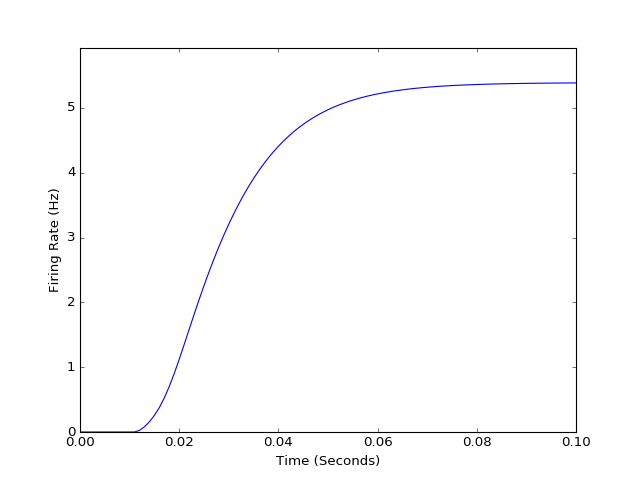

In [1]:
%matplotlib notebook

import dipde
assert dipde.__version__ == '0.2.1'
import logging
logging.disable(logging.CRITICAL)

b1 = dipde.ExternalPopulation('100*Heaviside(t)')
i1 = dipde.InternalPopulation(v_min=0, v_max=.02, dv=.001, 
                              p0={'distribution':'delta', 'loc':0}, 
                              update_method='approx', tol=1e-12, 
                              tau_m=.02)
b1_i1 = dipde.Connection(b1, i1, 1, weights=.005, delays=.01)
network = dipde.Network([b1, i1], [b1_i1])
network.run(dt=.001, tf=.1)

ax = i1.plot(show=True)

<a id='knight_sirovich' href='#knight_sirovich_first_ref'>[1]</a>  Knight, N.W., Manin, D., & Sirovich, L. (1996) <a href=http://www.brown.edu/academics/applied-mathematics/sites/brown.edu.academics.applied-mathematics/files/uploads/Dynamical%20models%20of%20interacting%20neuron%20populations%20in%20visual%20cortex.pdf> Dynamical models of interacting neuron populations in visual cortex </a>. Symposium on Robotics and Cybernetics; Computational Engineering in Systems Application: 1–5.

<a id='knight_sirovich_2' href='#knight_sirovich_2_first_ref'>[2]</a>  Omurtag, A., Knight, B.W., & Sirovich, L. (2000) <a href=http://www.ncbi.nlm.nih.gov/pubmed/10798499> On the Simulation of Large Populations of Neurons</a>. Journal of Computational Neuroscience 8: 51–63.

<a id='de_kamps' href='#de_kamps_first_ref'>[3]</a>  de Kamps M. (2003) <a href=http://www.mitpressjournals.org/doi/abs/10.1162/089976603322297322?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed&#.VYH9oxNViko> A simple and stable numerical solution for the population density equation</a>. Neural Computation 15: 2129–2146.





